## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import lightning.pytorch as pl
from torchsummary import summary
from torchmetrics import Accuracy
import itertools
import random
import cv2
print(torch.__version__)

2.0.1


## Hyperparameters

In [2]:
learning_rate = 1e-02
weight_decay = 1e-04
batch_size = 256
epochs = 40
img_size = (33,33)
train_size = 0.8
num_classes = 8
permutations = {0: [1,2,3,4,5,6,7,8],
                1: [0,2,3,4,5,6,7,8],
                2: [0,1,3,4,5,6,7,8],
                3: [0,1,2,4,5,6,7,8],
                4: [0,1,2,3,5,6,7,8],
                5: [0,1,2,3,4,6,7,8],
                6: [0,1,2,3,4,5,7,8],
                7: [0,1,2,3,4,5,6,8],
                8: [0,1,2,3,4,5,6,7]}

## Downloading and Loading Data

In [3]:
class Cifar10Dataset(Dataset):
    def __init__(self, images, transforms = None):
        self.images = images
        self.transforms = transforms
        self.permutations = {0: [1,2,3,4,5,6,7,8],
                             1: [0,2,3,4,5,6,7,8],
                             2: [0,1,3,4,5,6,7,8],
                             3: [0,1,2,4,5,6,7,8],
                             4: [0,1,2,3,5,6,7,8],
                             5: [0,1,2,3,4,6,7,8],
                             6: [0,1,2,3,4,5,7,8],
                             7: [0,1,2,3,4,5,6,8],
                             8: [0,1,2,3,4,5,6,7]}

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        if self.transforms:
            img = self.transforms(img)
        orig_img = img
        # Generating patches
        patches = []
        for i in range(9):
            row, col = i//3, i%3
            row_start, row_end = row*11, row*11+11
            col_start, col_end = col*11, col*11+11
            patches.append(orig_img[:, row_start:row_end, col_start:col_end])
        patch_1_idx = np.random.randint(9)
        relative_position = np.random.randint(8)
        patch_2_idx = self.permutations[patch_1_idx][relative_position]
        patch_1 = patches[patch_1_idx]
        patch_2 = patches[patch_2_idx]
        patched_img = torch.zeros_like(orig_img)
        for i in range(9):
            row, col = i//3, i%3
            row_start, row_end = row*11, row*11+11
            col_start, col_end = col*11, col*11+11
            if i == patch_1_idx or i == patch_2_idx:
                patched_img[:, row_start:row_end, col_start:col_end] = patches[i]
        return orig_img, patched_img, patch_1, patch_2, patch_1_idx, relative_position

In [4]:
cifar10_train = datasets.CIFAR10('./data/', train=True, transform=None)
cifar10_test = datasets.CIFAR10('./data', train=False)

In [5]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

valid_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.ToTensor()
])

all_idxs = np.arange(len(cifar10_train))
random.shuffle(all_idxs)
train_idxs = all_idxs[:int(train_size*len(all_idxs))]
valid_idxs = all_idxs[int(train_size*len(all_idxs)):]


train_dataset = Cifar10Dataset(cifar10_train.data[train_idxs], train_transforms)
valid_dataset = Cifar10Dataset(cifar10_train.data[valid_idxs], valid_transforms)
test_dataset = Cifar10Dataset(cifar10_test.data, test_transforms)
trainloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

## Visualizing Data

In [6]:
def images_visualization(orig_images, permuted_image, title1, title2):
    fig, axes = plt.subplots(nrows=8, ncols=17, figsize=(17,8))
    orig_images = orig_images[:64]
    permuted_image = permuted_image[:64]
    for idx, (img1, img2) in enumerate(zip(orig_images, permuted_image)):
        row_num = idx // 8
        col_num1 = idx % 8
        col_num2 = idx % 8 + 9

        # Display the first set of kernels
        if img1.ndim == 3:
            axes[row_num][col_num1].imshow(img1.permute(1,2,0))
        else:
            axes[row_num][col_num1].imshow(img1, cmap = 'gray')
        axes[row_num][col_num1].axis('off')
        
        # Display the second set of kernels
        if img2.ndim == 3:
            axes[row_num][col_num2].imshow(img2.permute(1,2,0))
        else:
            axes[row_num][col_num2].imshow(img2, cmap = 'gray')
        axes[row_num][col_num2].axis('off')

    for row_num in range(8):
        axes[row_num][8].axis('off')
        
    # Add titles for the first and second set of kernels
    axes[0][3].set_title(title1,fontsize=20)
    axes[0][12].set_title(title2,fontsize=20)

    plt.tight_layout()
    plt.show()

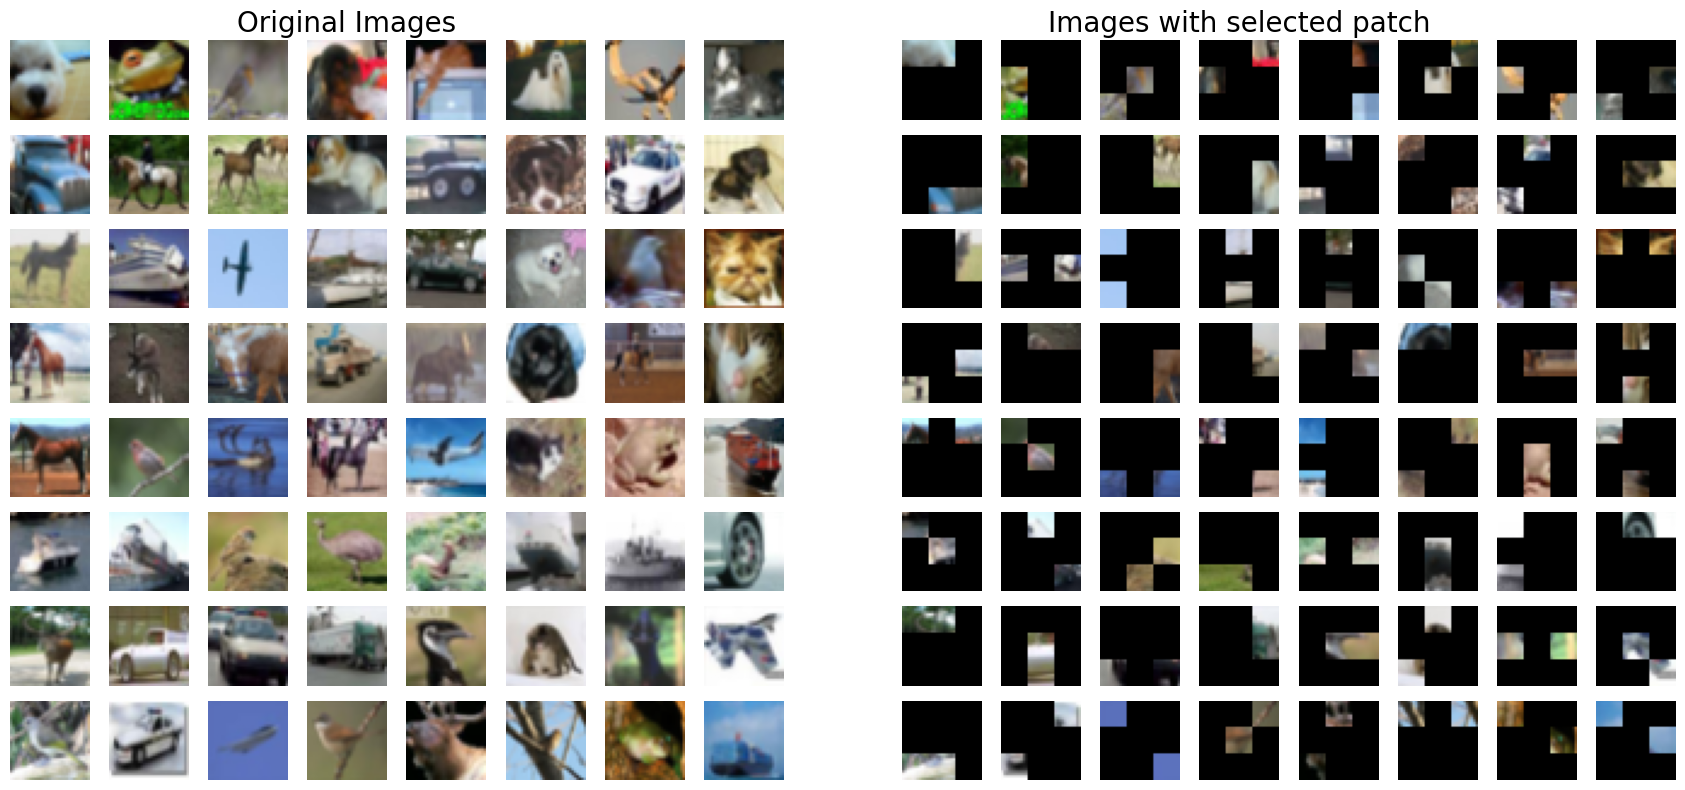

In [7]:
orig_img, patched_img, patch_1, patch_2, patch_1_idx, relative_position = next(iter(trainloader))
images_visualization(orig_img, patched_img, "Original Images", "Images with selected patch")

## Model Building


In [8]:
class PatchPrediction(pl.LightningModule):
    def __init__(self, num_classes, lr = 1e-02, weight_decay = 1e-04):
        super().__init__()
        self.generate_model(num_classes)
        self.loss_fxn()
        self.accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.lr = lr
        self.weight_decay = weight_decay

    def training_step(self, batch, batch_idx):
        _, _, patch_1, patch_2, _, relative_position = batch
        preds = self(patch_1, patch_2)
        loss = self.criterion(preds, relative_position)
        train_acc = self.accuracy(preds, relative_position)
        self.log_dict({'Train_loss': loss, 'train_acc': train_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        _, _, patch_1, patch_2, _, relative_position = batch
        preds = self(patch_1, patch_2)
        val_loss = self.criterion(preds, relative_position)
        val_acc = self.accuracy(preds, relative_position)
        self.log_dict({'Valid_loss': val_loss, 'valid_acc': val_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        _, _, patch_1, patch_2, _, relative_position = batch
        preds = self(patch_1, patch_2)
        test_loss = self.criterion(preds, relative_position)
        test_acc = self.accuracy(preds, relative_position)
        self.log_dict({"Test_loss": test_loss, 'test_acc': test_acc}, on_step = False, on_epoch = True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = self.lr, weight_decay=self.weight_decay)
        return optimizer

    def loss_fxn(self):
        self.criterion = nn.CrossEntropyLoss()

    def generate_model(self, num_classes):
        self.featureExtractor = nn.Sequential(self.conv_block(3, 32, 3, 1, 1),
                                              self.conv_block(32, 64, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(64, 64, 3, 1, 1),
                                              self.conv_block(64, 128, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(128, 128, 3, 1, 1),
                                              self.conv_block(128, 256, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Flatten()
                                              )
        self.output = nn.Sequential(nn.Dropout(p = 0.5),
                                    nn.Linear(256*2, 2048), # 9 since that is the number of patches
                                    nn.BatchNorm1d(num_features=2048),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(2048, num_classes)
                                   )
        self.output.apply(self.init_weights)

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                            nn.BatchNorm2d(num_features=out_channels),
                            nn.ReLU(inplace=True),
                            )
        block.apply(self.init_weights)
        return block

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            torch.nn.init.xavier_normal_(layer.weight)
        elif isinstance(layer, nn.Linear):
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.0)

    def forward(self, patch_1, patch_2):
        patch_1_embedding = self.featureExtractor(patch_1)
        patch_2_embedding = self.featureExtractor(patch_2)
        features = torch.cat((patch_1_embedding, patch_2_embedding), dim = -1)
        out = self.output(features)
        return out

## Training the model

In [ ]:
torch.set_float32_matmul_precision('medium')
patch_prediction = PatchPrediction(num_classes, learning_rate, weight_decay)
trainer = pl.Trainer(max_epochs = epochs, devices=[1], log_every_n_steps=10)
trainer.fit(patch_prediction, trainloader, validloader)

In [10]:
metric = pd.read_csv('lightning_logs/version_2/metrics.csv')
metric.head()

,step,epoch,Valid_loss,valid_acc,train_acc,Train_loss
0,156,0,2.082631,0.1548,NaN,NaN
1,156,0,NaN,NaN,0.13505,2.489151
2,313,1,1.953540,0.2121,NaN,NaN
3,313,1,NaN,NaN,0.17400,2.063573
4,470,2,2.898076,0.1944,NaN,NaN


In [11]:
valid_losses = metric[~metric['Valid_loss'].isna()]['Valid_loss'].values
train_losses = metric[~metric['Train_loss'].isna()]['Train_loss'].values
valid_accuracy = metric[~metric['valid_acc'].isna()]['valid_acc'].values
train_accuracy = metric[~metric['train_acc'].isna()]['train_acc'].values

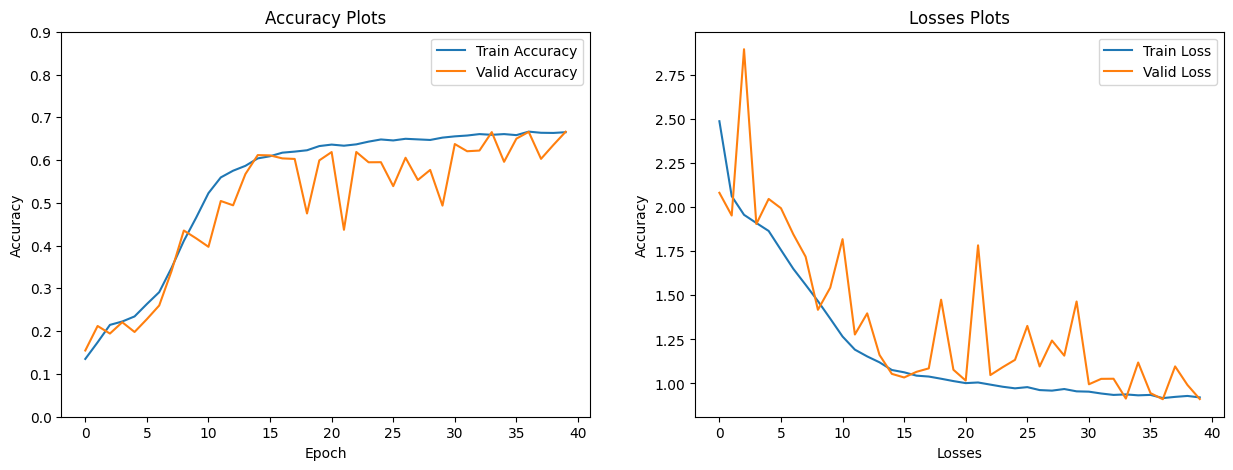

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_accuracy, label="Train Accuracy")
axes[0].plot(valid_accuracy, label="Valid Accuracy")
axes[0].set_title('Accuracy Plots')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(train_losses, label="Train Loss")
axes[1].plot(valid_losses, label="Valid Loss")
axes[1].set_title('Losses Plots')
axes[1].set_xlabel('Losses')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

## Final Results

In [13]:
trainer.test(patch_prediction, dataloaders=testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test_loss           0.9061920642852783
        test_acc            0.6660000085830688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'Test_loss': 0.9061920642852783, 'test_acc': 0.6660000085830688}]

In [14]:
def repatch_images(patch_1, patch_2, patch_1_idx, predicted_patch_idx):
    patch_2_idx = permutations[int(patch_1_idx)][int(predicted_patch_idx)]
    patched_img = torch.zeros((3,33,33))
    for i in range(9):
        row, col = i//3, i%3
        row_start, row_end = row*11, row*11+11
        col_start, col_end = col*11, col*11+11
        if i == patch_1_idx:
            patched_img[:, row_start:row_end, col_start:col_end] = patch_1.detach().cpu()
        if i == patch_2_idx:
            patched_img[:, row_start:row_end, col_start:col_end] = patch_2.detach().cpu()
    return patched_img

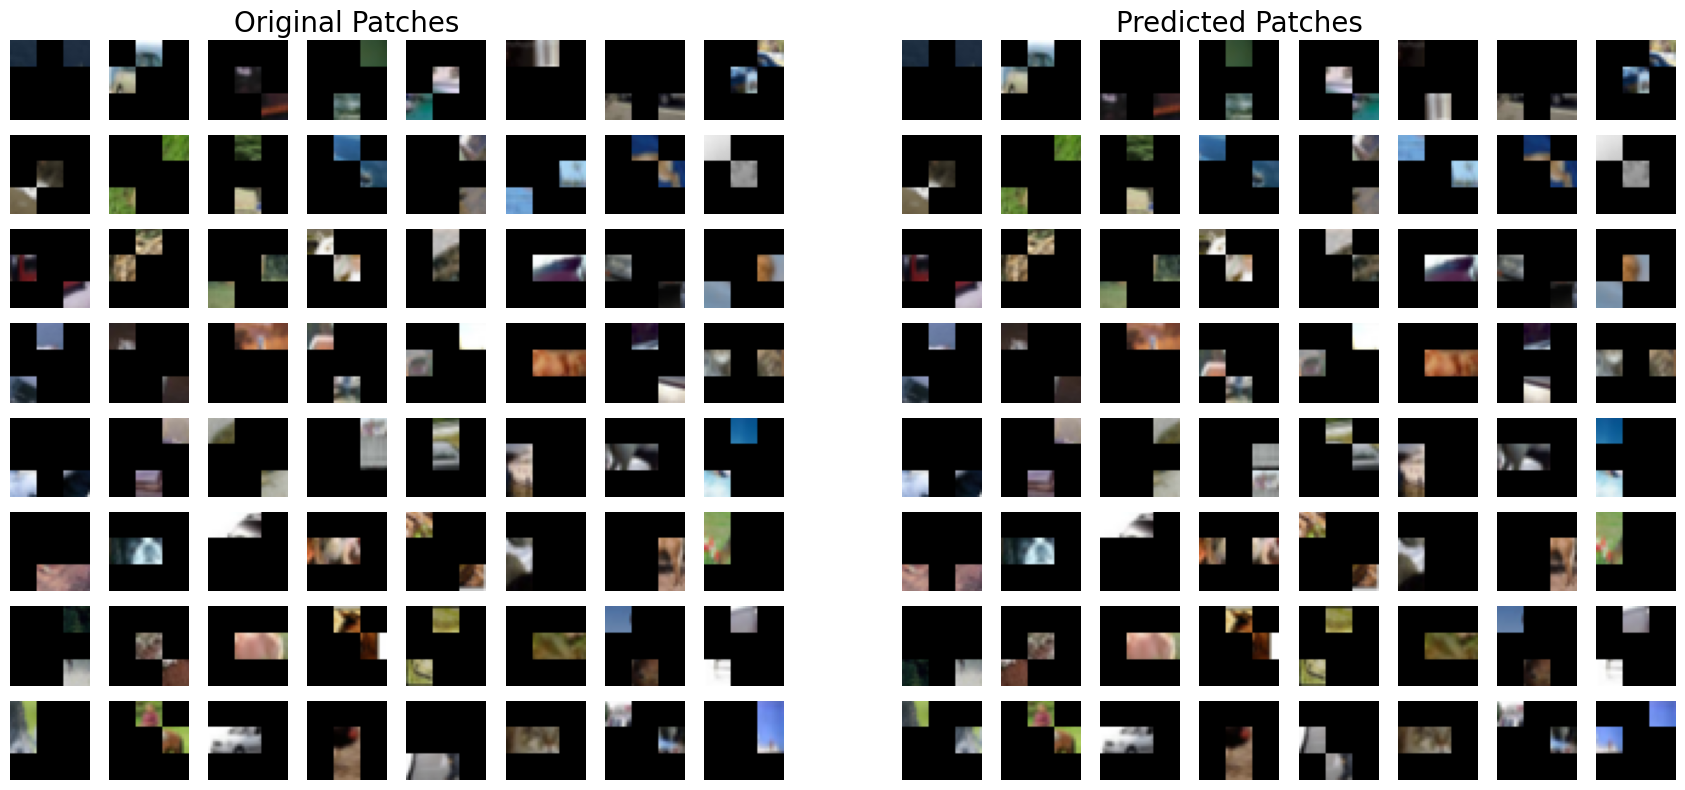

In [22]:
orig_img, patched_img, patch_1, patch_2, patch_1_idx, relative_position = next(iter(validloader))
predictions = torch.max(patch_prediction(patch_1, patch_2), axis = -1)[1]
predicted_patch_position = torch.zeros_like(orig_img)
for i in range(len(orig_img)):
    predicted_patch_position[i] = repatch_images(patch_1[i], patch_2[i], patch_1_idx[i], predictions[i])
images_visualization(patched_img, predicted_patch_position, 'Original Patches', 'Predicted Patches')

## Downstream Task (Cifar 10 Classification)

In [16]:
train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor()
])
cifar10_train = datasets.CIFAR10('./data/', train=True, transform=train_transforms)
cifar10_test = datasets.CIFAR10('./data', train=False, transform=test_transforms)

In [17]:
train_loader = DataLoader(cifar10_train, batch_size=batch_size, num_workers=2, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, num_workers=2)

In [18]:
class ClassificationModel(pl.LightningModule):
    def __init__(self, num_classes, num_freeze = -1):
        super().__init__()
        self.generate_model(num_classes)
        self.loss_fxn()
        self.freeze_layers(num_freeze)
        self.accuracy = Accuracy(task='multiclass', num_classes=10)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.reshape(-1,)
        preds = self(images)
        loss = self.criterion(preds, labels)
        train_acc = self.accuracy(preds, labels)
        self.log_dict({'Train_loss': loss, 'train_acc': train_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.reshape(-1,)
        preds = self(images)
        val_loss = self.criterion(preds, labels)
        val_acc = self.accuracy(preds, labels)
        self.log_dict({'Valid_loss': val_loss, 'valid_acc': val_acc}, on_step = False, on_epoch = True, prog_bar = True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.reshape(-1,)
        preds = self(images)
        test_loss = self.criterion(preds, labels)
        test_acc = self.accuracy(preds, labels)
        self.log_dict({"Test_loss": test_loss, 'test_acc': test_acc}, on_step = False, on_epoch = True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 1e-02)
        return optimizer

    def loss_fxn(self):
        self.criterion = nn.CrossEntropyLoss()

    def generate_model(self, num_classes):
        self.featureExtractor = nn.Sequential(self.conv_block(3, 32, 3, 1, 1),
                                              self.conv_block(32, 64, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(64, 64, 3, 1, 1),
                                              self.conv_block(64, 128, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              self.conv_block(128, 128, 3, 1, 1),
                                              self.conv_block(128, 256, 3, 1, 1),
                                              nn.MaxPool2d(kernel_size=2),
                                              nn.Flatten()
                                              )
        self.output = nn.Sequential(nn.Dropout(p = 0.5),
                                    nn.Linear(256*2, 2048), # 9 since that is the number of patches
                                    nn.BatchNorm1d(num_features=2048),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(2048, num_classes)
                                   )
        self.output.apply(self.init_weights)

    def conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                            nn.BatchNorm2d(num_features=out_channels),
                            nn.ReLU(inplace=True),
                            )
        block.apply(self.init_weights)
        return block

    def init_weights(self, layer):
        if isinstance(layer, nn.Conv2d):
            torch.nn.init.xavier_normal_(layer.weight)
        elif isinstance(layer, nn.Linear):
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.0)

    def freeze_layers(self, num_freeze):
        for idx, child in enumerate(self.featureExtractor.children()):
            # Freeze all layers
            if num_freeze == -1:
                for param in child.parameters():
                    param.requires_grad = False
                continue

            else:
                if idx >= num_freeze:
                    break
                for param in child.parameters():
                    param.requires_grad = False

    def forward(self, x):
        features = self.featureExtractor(x)
        out = self.output(features)
        return out

In [19]:
classification_model = ClassificationModel(num_classes=num_classes, num_freeze=7)
checkpoint = torch.load('./lightning_logs/version_2/checkpoints/epoch=39-step=6280.ckpt')
classification_model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [20]:
# Removing the output with classifier
classification_model.output = nn.Sequential(nn.Dropout(p = 0.5),
                                    nn.Linear(4096, 2048),
                                    nn.BatchNorm1d(num_features=2048),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(2048, 10) # Since CIFAR 10 have 10 classes
                                   )

Training with only classifier layer unfreezed and other feature extractor layers freezed

In [ ]:
epochs = 20
trainer = pl.Trainer(max_epochs = epochs, devices=[1], log_every_n_steps=10)
trainer.fit(classification_model, train_loader, test_loader)

In [23]:
metric = pd.read_csv('lightning_logs/version_3/metrics.csv')
metric.head()

,step,epoch,Valid_loss,valid_acc,train_acc,Train_loss
0,195,0,1.576909,0.4471,NaN,NaN
1,195,0,NaN,NaN,0.37206,1.895180
2,391,1,1.457635,0.4839,NaN,NaN
3,391,1,NaN,NaN,0.44556,1.551471
4,587,2,1.414335,0.4991,NaN,NaN


In [24]:
valid_losses = metric[~metric['Valid_loss'].isna()]['Valid_loss'].values
train_losses = metric[~metric['Train_loss'].isna()]['Train_loss'].values
valid_accuracy = metric[~metric['valid_acc'].isna()]['valid_acc'].values
train_accuracy = metric[~metric['train_acc'].isna()]['train_acc'].values

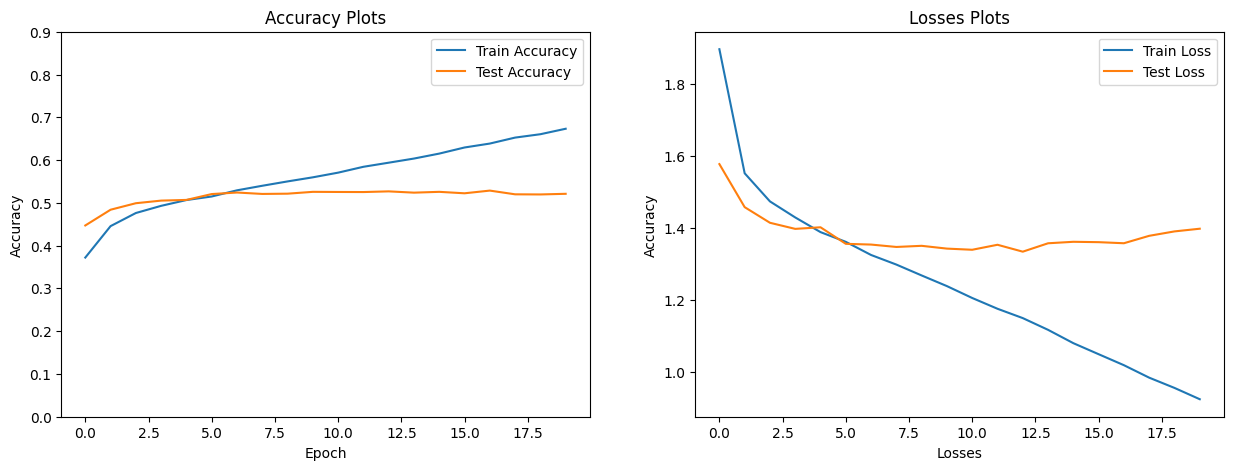

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(train_accuracy, label="Train Accuracy")
axes[0].plot(valid_accuracy, label="Test Accuracy")
axes[0].set_title('Accuracy Plots')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0.0, 1.0, 0.1))
axes[0].legend()

axes[1].plot(train_losses, label="Train Loss")
axes[1].plot(valid_losses, label="Test Loss")
axes[1].set_title('Losses Plots')
axes[1].set_xlabel('Losses')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.show()

## GradCam Visualization

In [26]:
imgs, lbls = next(iter(test_loader))

In [27]:
def gradcam_visualization(img, model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img = img.to(device)[None]
    model = model.to(device)
    model.unfreeze()
    model.eval()
    activation_network = model.featureExtractor[:-3]
    category = model(img)
    category = torch.max(category, dim = -1)[0]
    feature_maps = activation_network(img)
    model.zero_grad()
    category.backward(retain_graph = True)
    gradients_mean = model.featureExtractor[-3][0].weight.grad.data.mean((0,2,3))
    for i in range(len(gradients_mean)):
        feature_maps[:,i, :, :] *= gradients_mean[i]
    heatmap = torch.mean(feature_maps, dim = 1)[0].cpu().detach()
    heatmap = heatmap.numpy()
    min_value, max_value = heatmap.min(), heatmap.max()
    heatmap = 255*((heatmap - min_value)/(max_value - min_value))
    heatmap = heatmap.astype(np.uint8)
    img = 255*np.transpose(img[0].detach().cpu().numpy(), (1,2,0))
    heatmap = cv2.resize(heatmap, img.shape[:-1])
    heatmap = 255 - heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET).astype(np.uint8)
    heatmap = (0.3*heatmap + 0.7*img).astype(np.uint8)
    heatmap = torch.permute(torch.tensor(heatmap), (2,0,1))/255.
    return heatmap

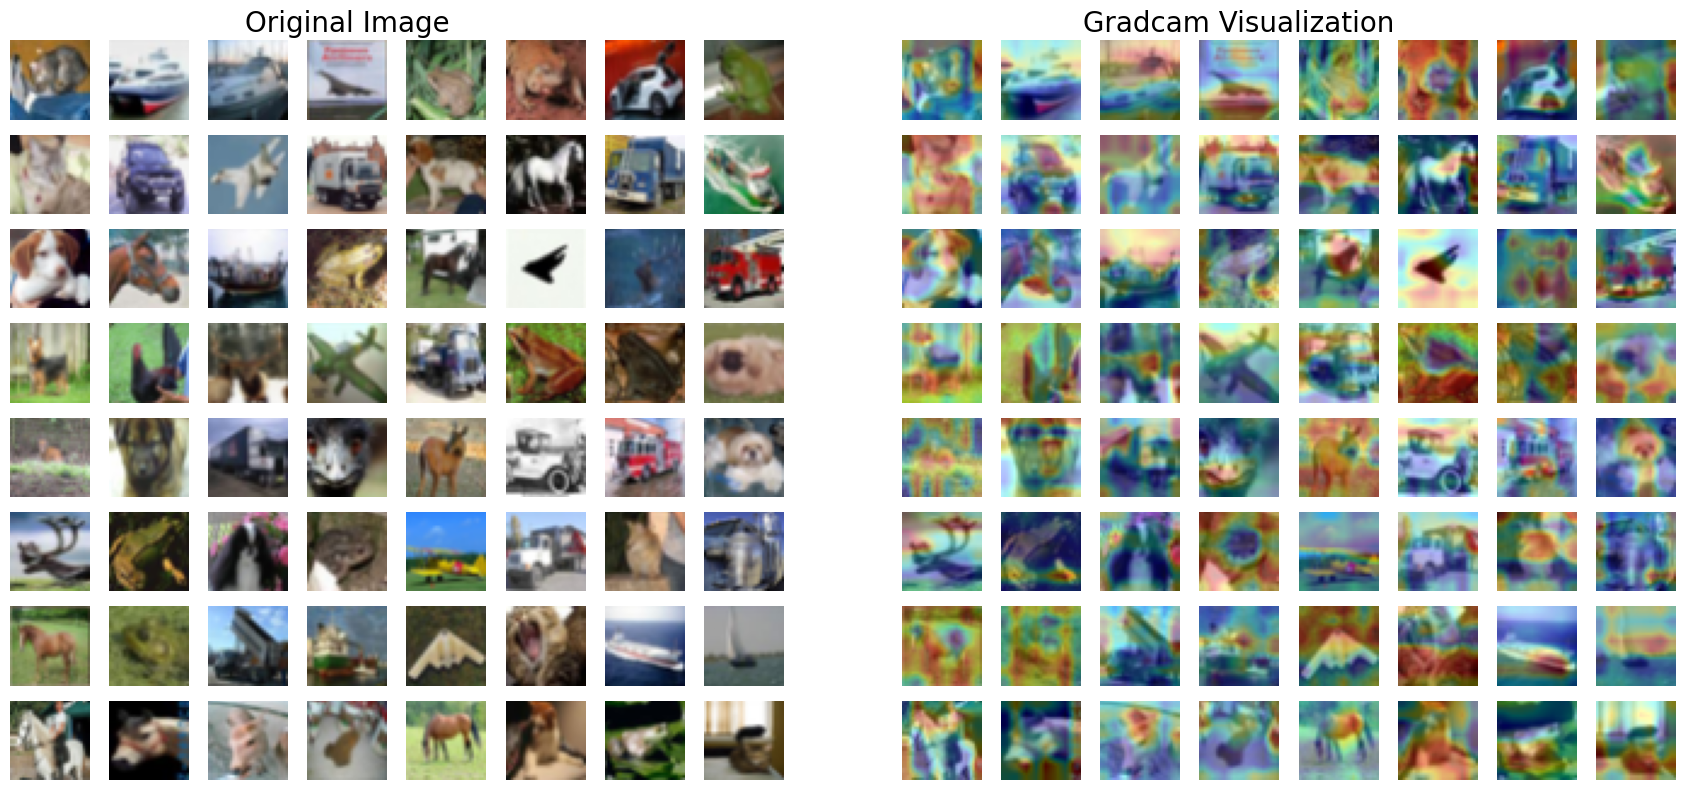

In [28]:
imgs, lbls= next(iter(test_loader))
grad_cam_images = torch.zeros_like(orig_img)
for i in range(len(orig_img)):
    grad_cam_images[i] = gradcam_visualization(imgs[i], classification_model)
images_visualization(imgs, grad_cam_images, 'Original Image', 'Gradcam Visualization')